In [1]:
%reset

In [2]:
import os
from glob import glob 
import nibabel as nib
from matplotlib import pyplot as plt
import benford as bf
import numpy as np
import pandas as pd 

In [3]:
dataMRI = ('../input')
resultsDir = ('../output')
typeImage = 't1weighted.nii.gz'
extension = 'pdf'

In [4]:
confidenceValue = 95
degreesFreedom = 8
sd_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

In [5]:
pathMRI = sorted(glob(dataMRI + '/**/' + typeImage, recursive=True))
SIZE = len(pathMRI)

In [6]:
def load_image(filePath):
    image = nib.load(filePath)
    return image

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap='gray', origin="lower")

def length_of_decimals(data):
    numMax = data.max()
    integerPart = int(numMax) # the number's integer part
    lengthNum = len(str(integerPart))
    decimals = 19 - lengthNum
    return decimals

def ricianDistribution(img3D, sd, n, fixedSedd):
    if sd==0:
        return img3D
    np.random.seed(fixedSedd)
    distributionRandom1 = np.random.normal(size = img3D.shape)
    distributionRandom2 = np.random.normal(size = img3D.shape)
    # Generate the noise
    x = sd * n * distributionRandom1 + img3D
    y = sd * n * distributionRandom2
    module = np.sqrt(pow(x, 2) + pow(y, 2))
    # Return the image with noise 
    return  module

def bhattacharyya_distance(distribution1, distribution2):
    return -np.log(bhattacharyya_coefficient(distribution1, distribution2))

def bhattacharyya_coefficient(distribution_1, distribution_2):
    return np.sum(np.sqrt(distribution_1 * distribution_2))

def kullbackLeibler_divergence(distribution_1, distribution_2):
    return np.sum(np.where(distribution_1 != 0, distribution_1 * np.log(distribution_1/ distribution_2),0))

def benfordComparative(img1D, decimal, confidenceVal, df):
    fd_img = bf.first_digits(img1D, digs=1, decimals=decimal, MAD=False, confidence=confidenceVal, chi_square=False, KS=False, show_plot=False) 
    # Parameters
    bc = bhattacharyya_coefficient(fd_img.Found, fd_img.Expected)
    kd = kullbackLeibler_divergence(fd_img.Found, fd_img.Expected)
    # List with all values
    return [bc, kd]

PLOTTING AN MRI

Text(0.5, 0.98, 'MRI')

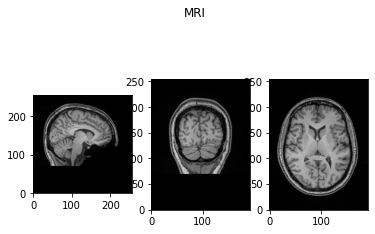

In [7]:
i=1
image_loaded = load_image(pathMRI[i])
actualImage = image_loaded.get_fdata()

data = actualImage

slice_0 = data[100, :, :]
slice_1 = data[:, 60, :]
slice_2 = data[:, :, 150]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("MRI") 

BENFORD STUDY

In [16]:
column_names = ["Noise", "Bhattacharyya_Coefficient", "KulbackLeiber_Divergence"]
df = pd.DataFrame(columns = column_names)

In [17]:
for i_img in range(0, SIZE):
    #It indicates the repository we are in: HLN=0, MMRR=1, NKI-RS=2, NKI-TRT=3
    i_rep = 2 

    # Load the image
    image_loaded = load_image(pathMRI[i_img])

    # Define actual image in 3D format
    actualImage = image_loaded.get_fdata()

    # Add 10 different noisy to each MRI, according to sd_range variable
    for noise in range(0, len(sd_range)):
        # Apply Rician noise
        image = ricianDistribution(
                        img3D=actualImage, 
                        sd=sd_range[noise], 
                        n=actualImage.max()-actualImage.min(), 
                        fixedSedd=i_rep +i_img)

        # Fast Fourier Transform
        image_FFT = np.fft.fftn(image).astype(np.int64)
        # Allowed decimals according to firs_digit function (benford package)
        ld_FFT = length_of_decimals(image_FFT)
        # Compare MRI distribution with Benford distribution. BC_FFT and KL_FFT are the matching measures.
        BC_FFT, KL_FFT = benfordComparative(img1D=image_FFT.ravel(), 
                                            decimal=ld_FFT, 
                                            confidenceVal=confidenceValue, 
                                            df=degreesFreedom)


        # Append to dataframe
        to_append = [sd_range[noise], BC_FFT, KL_FFT]
        df_length = len(df)
        df.loc[df_length] = to_append

<ipython-input-17-ceda45dbd89a>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  image_FFT = np.fft.fftn(image).astype(np.int64)

Initialized sequence with 12582636 registries.
First_1_Dig
1    0.269052
2    0.183125
3    0.141320
4    0.109410
5    0.085710
6    0.068065
7    0.055778
8    0.047001
9    0.040538
Name: Found, dtype: float64

Test performed on 12582636 registries.
Discarded 0 records < 1 after preparation.

The entries with the significant positive deviations are:

             Expected     Found     Z_score
First_1_Dig                                
3            0.124939  0.141320  175.735664
4            0.096910  0.109410  149.885686
5            0.079181  0.085710   85.768383
2            0.176091  0.183125   65.501372
6            0.066947  0.068065   15.872081
<ipython-input-17-ceda45dbd89a>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  image_FFT = np.fft.fftn(image).astype(np.int64)

Initialized 

In [18]:
#Save at .csv file
df.to_csv(os.path.join(resultsDir, 'BC_and_KL_10RicianNoises_MRI' + '.csv'), sep=',', header=True)

BOXPLOTS

In [11]:
labels = ['0.0','0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09']

In [19]:
boxprops = dict(linestyle='-', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='tab:red')

whiskerprops = dict(linestyle='-', linewidth=1, color='k')
meanprops = dict(marker='d', markerfacecolor='tab:green', markersize=3, markeredgecolor='tab:green')
flierprops = dict(marker=',', markerfacecolor='k', markersize=3,
                  linestyle='none', markeredgecolor='k')

In [20]:
def boxplot_function(columnName, yLabel, outputFile_name):
    df.boxplot(column=columnName, 
                 by='Noise', 
                 return_type='both', 
                 showmeans=True,
                 boxprops=boxprops, 
                 medianprops=medianprops, 
                 meanprops=meanprops, 
                 whiskerprops=whiskerprops , 
                 flierprops=flierprops, 
                 grid=False, 
                 rot=0, 
                 figsize=(12, 6), 
                 patch_artist=False,
                 labels=labels)
                
    plt.title('')
    plt.suptitle('')

    plt.tick_params(axis='both', labelsize=20)
    plt.xlabel('Noise', size=20)
    plt.ylabel(yLabel, size=20) # that's what you're after

    plt.savefig(os.path.join(resultsDir, outputFile_name + '_boxplot.pdf'))

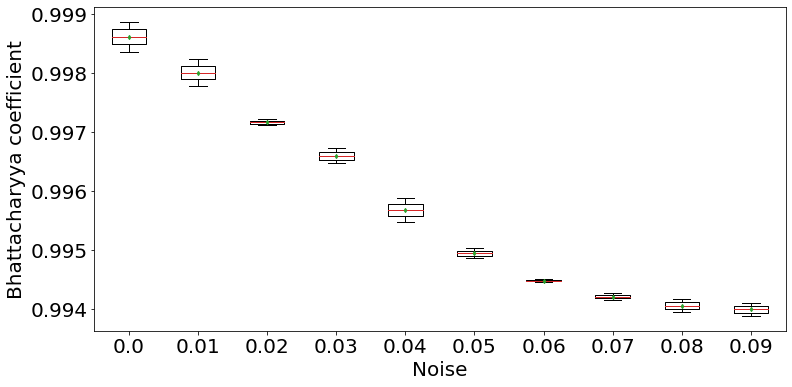

In [21]:
# Boxplot
outputFile_name_Bhat = 'MRI_BC'
boxplot_function(columnName = 'Bhattacharyya_Coefficient', 
                 yLabel = 'Bhattacharyya coefficient', 
                 outputFile_name = outputFile_name_Bhat)

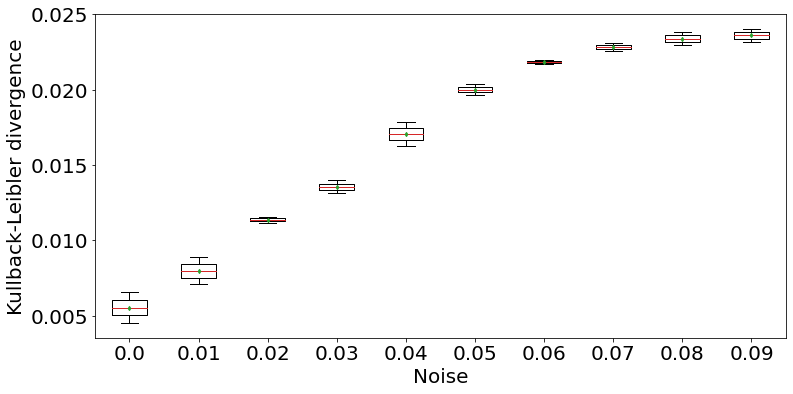

In [22]:
# Boxplot
outputFile_name_Kul = 'MRI_KL'
boxplot_function(columnName = 'KulbackLeiber_Divergence', 
                 yLabel = 'Kullback-Leibler divergence', 
                 outputFile_name = outputFile_name_Kul) 